2023-02-02

In [4]:
%%html
<img src="3.jpg"/>

# Air Pollution with Recurrent Neural Networks

LSTM models for univariate time series forecasting.

LSTM models for multivariate time series forecasting.

Information about data.


This hourly dataset contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorologigal data from Beijing Capital International Airport are also included.

Attribute Information:

No: row number

year: year of data in this row

month: month of data in this row

day: day of data in this row

hour: hour of data in this row

pm2.5: PM 2.5 concentration (ug/m^3)

DEWP: Dew Point (a,,f)
(the temperature to which air must be cooled to become saturated with water vapor, assuming constant air pressure and water content.)

TEMP:Temperature (a,,f)

PRES: Pressure (hPa)

cbwd: Combined wind direction

lws: Cumulated wind speed (m/s)

Is: Cumulated hours of snow

Ir: Cumulated hours of rain 

Import libraries
# 1. Importing the needed libraries

In [6]:
# for processing and analysis of structured data
import pandas as pd

# For mathematical calculations, statistics, matrix
import numpy as np
import math

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#To prepare dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# For create and training model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten

# To evaluate the performance of the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

import scipy.stats as stats

In [7]:
def diagnostic_plots(data, variable):
    plt.figure(figsize = (10, 4))
    plt.subplot(1, 3, 1)
    data[variable].hist()
    
    plt.subplot(1, 3, 2)
    stats.probplot(data[variable], dist = 'norm', plot = plt)
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y = data[variable])
    plt.title("Boxplot")
    
    plt.show()

# 2. Loading the dataset

In [8]:
# Import Dataset
data = pd.read_csv('./pollution_for_6th.csv')
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [9]:
data.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [72]:
# Information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


# 3.Feature enginerring

In [73]:
#To check for NA
data.isnull().mean()

No       0.000000
year     0.000000
month    0.000000
day      0.000000
hour     0.000000
pm2.5    0.047166
DEWP     0.000000
TEMP     0.000000
PRES     0.000000
cbwd     0.000000
Iws      0.000000
Is       0.000000
Ir       0.000000
dtype: float64

In [74]:
pollution_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean'))
])

In [75]:
# To turn dates of year, month, day into an index
data.index = pd.to_datetime(data[['year', 'month', 'day']], format = '%Y %m %d %H')

data = data.drop(columns = ['No', 'year', 'month', 'day', 'hour'])

data = data.rename(columns = {
    'pm2.5': 'pollution',
    'DEWP': 'dew_point',
    "TEMP": 'temperature',
    'PRES': 'presure',
    'cbwd': 'wind_direction',
    'Iws': 'wind_speed',
    'Is': 'snow',
    'Ir': 'rain'
})

In [77]:
data.shape

(43800, 8)

<AxesSubplot:>

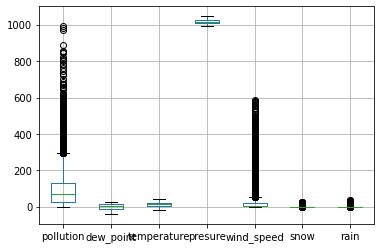

In [78]:
data.boxplot()

In [ ]:
# outlier in pollution and wind speed

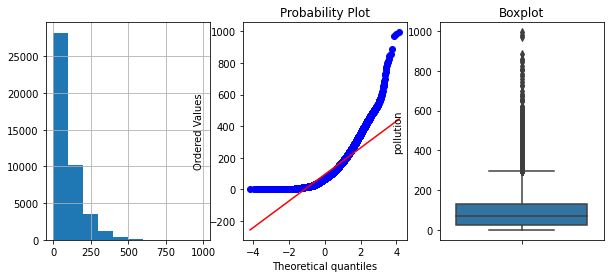

In [79]:
diagnostic_plots(data, 'pollution')

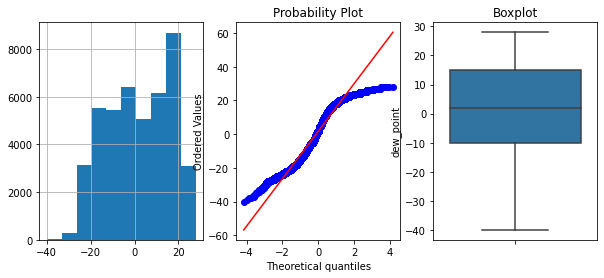

In [80]:
diagnostic_plots(data, 'dew_point')

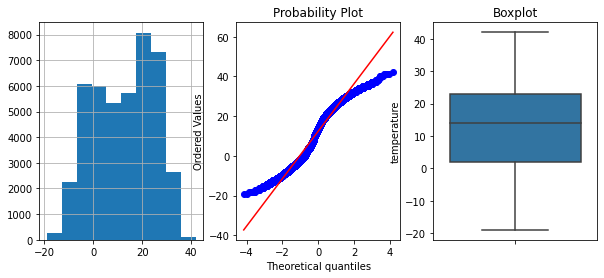

In [81]:
diagnostic_plots(data, 'temperature')

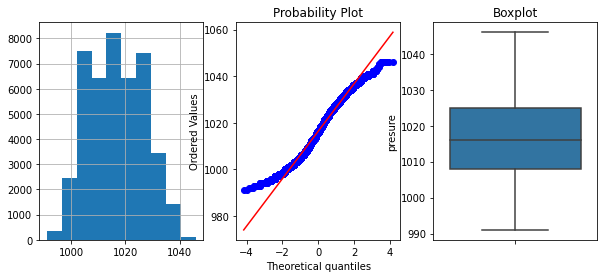

In [82]:
diagnostic_plots(data, 'presure')

In [5]:
# The distribution is uneven everywhere.

# 4. Dataset preprocessing

In [83]:
# Encode values
label_encoder = LabelEncoder()

data['wind_direction'] = label_encoder.fit_transform(data['wind_direction'])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

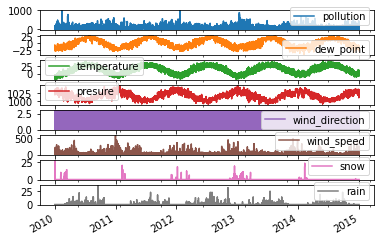

In [84]:
data.plot(subplots = True)

Meteorological feature
Weather parameters (dew point, atmospheric temperature, atmospheric pressure, wind direction, wind speed, snow, rain relative humidity) affect air quality. For example, high wind speed will reduce the concentration of PM2.5
, high humidity generally worsens air pollution, and high air pressure generally results in good air quality [50, 51]. Therefore, meteorological parameters are of prime importance for the task of forecasting air quality

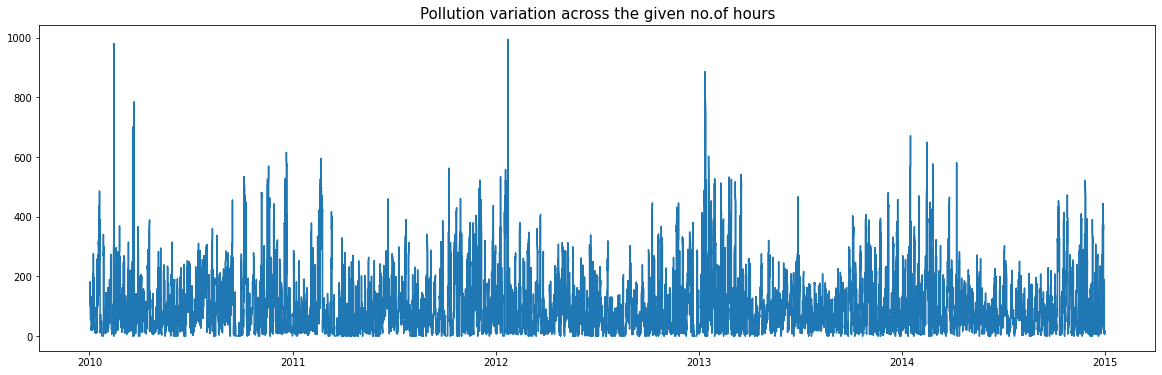

In [85]:
fig = plt.figure(figsize = (20,6))
plt.plot(data.pollution)
plt.title("Pollution variation across the given no.of hours", fontsize = 15)
plt.show()

Pollution is observed in the cold months

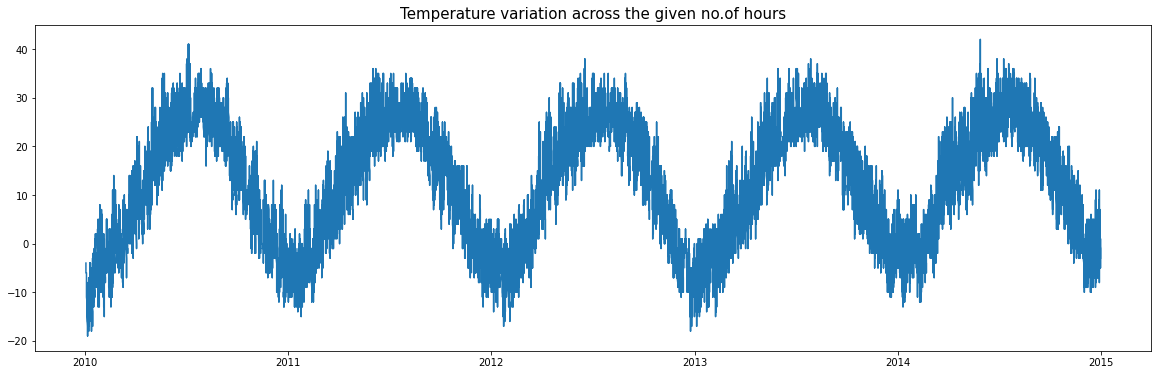

In [86]:
fig = plt.figure(figsize = (20,6))
plt.plot(data.temperature)
plt.title("Temperature variation across the given no.of hours", fontsize = 15)
plt.show()

According to the plot, we see that from the beginning of the year to the middle of the year, the temperature rises.

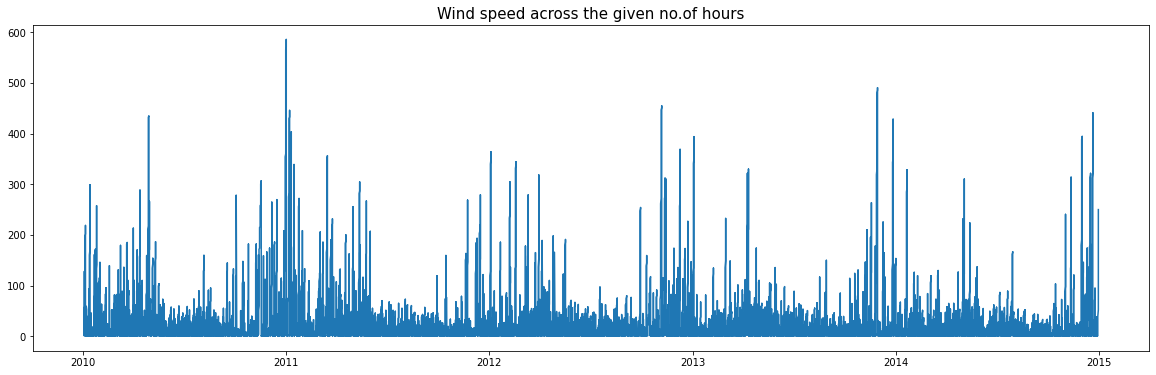

In [87]:
fig = plt.figure(figsize = (20,6))
plt.plot(data.wind_speed)
plt.title("Wind speed across the given no.of hours", fontsize = 15)
plt.show()

Stronger winds are observed in the cold season

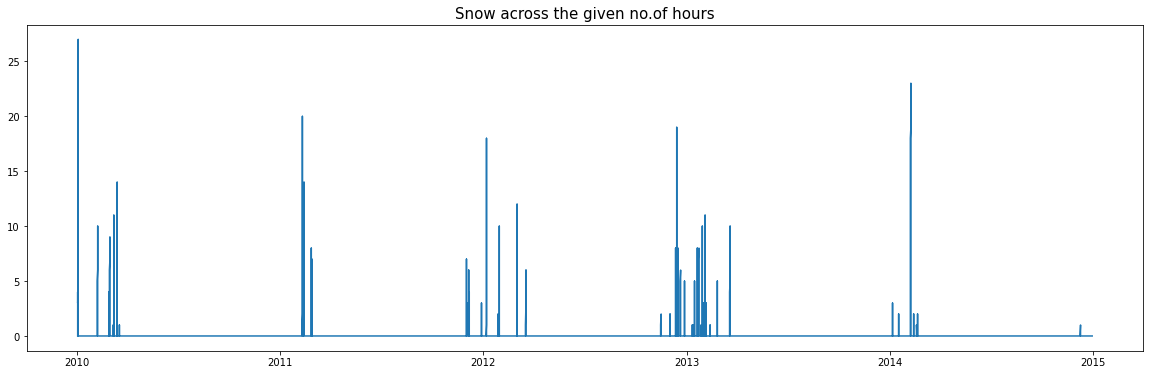

In [88]:
fig = plt.figure(figsize = (20,6))
plt.plot(data.snow)
plt.title("Snow across the given no.of hours", fontsize = 15)
plt.show()

Snow falls before the beginning of the year and after in the cold months of the winter period

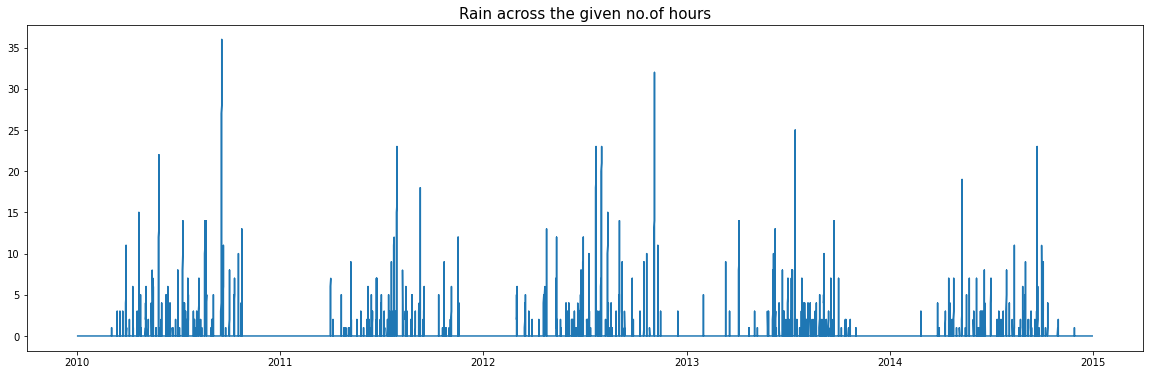

In [89]:
fig = plt.figure(figsize = (20,6))
plt.plot(data.rain)
plt.title("Rain across the given no.of hours", fontsize = 15)
plt.show()

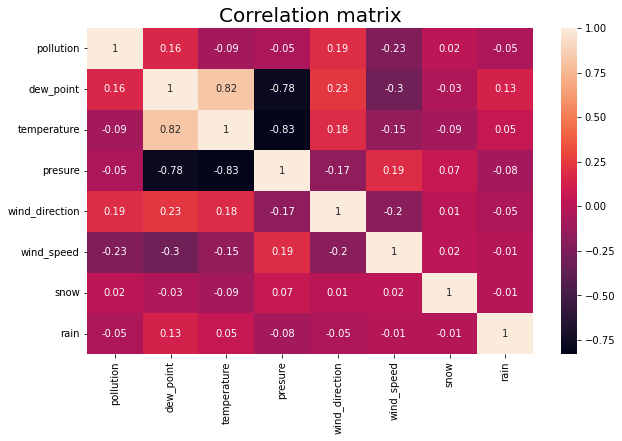

In [90]:
# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(data.corr().round(2),annot=True)
plt.title('Correlation matrix',fontsize = 20)
plt.show()

Air quality feature
In the atmosphere, we detect different pollutants, the increase of their concentrations negatively affects the quality of the air. We calculated the correlations between the features, of the air quality and we found a high correlation value between dew point atmospheric temperature and atmospheric pressure.

In [91]:
data.drop(['dew_point', 'presure'], axis = 1, inplace = True)

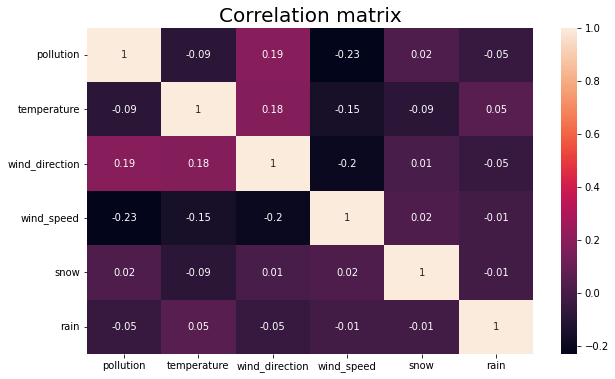

In [92]:
# Correlation matrix after remove 'dew_point', 'presure'
plt.figure(figsize=(10,6))
sns.heatmap(data.corr().round(2),annot=True)
plt.title('Correlation matrix',fontsize = 20)
plt.show()

After removing correlative variables in the correlation matrix, there are no more variables that correlate with each other.

In [93]:
# Normalising data
scaler = MinMaxScaler(feature_range= (0, 1))
values = scaler.fit_transform(data)

In [94]:
dat = pd.DataFrame(values)

dat.columns = dat.columns
dat.index = dat.index

dat.head(10)

,0,1,2,3,4,5
0,0.129779,0.245902,0.666667,0.002290,0.000000,0.0
1,0.148893,0.245902,0.666667,0.003811,0.000000,0.0
2,0.159960,0.229508,0.666667,0.005332,0.000000,0.0
3,0.182093,0.229508,0.666667,0.008391,0.037037,0.0
4,0.138833,0.229508,0.666667,0.009912,0.074074,0.0
5,0.109658,0.213115,0.666667,0.011433,0.111111,0.0
6,0.105634,0.213115,0.666667,0.014492,0.148148,0.0
7,0.124748,0.229508,0.666667,0.017551,0.000000,0.0
8,0.120724,0.213115,0.666667,0.020610,0.000000,0.0
9,0.132797,0.229508,0.666667,0.023669,0.000000,0.0


In [95]:
data['predicted_pollution'] = data ['pollution'].shift(-1) 

data

,pollution,temperature,wind_direction,wind_speed,snow,rain,predicted_pollution
2010-01-02,129.0,-4.0,2,1.79,0,0,148.0
2010-01-02,148.0,-4.0,2,2.68,0,0,159.0
2010-01-02,159.0,-5.0,2,3.57,0,0,181.0
2010-01-02,181.0,-5.0,2,5.36,1,0,138.0
2010-01-02,138.0,-5.0,2,6.25,2,0,109.0
...,...,...,...,...,...,...,...
2014-12-31,8.0,-2.0,1,231.97,0,0,10.0
2014-12-31,10.0,-3.0,1,237.78,0,0,10.0
2014-12-31,10.0,-3.0,1,242.70,0,0,8.0
2014-12-31,8.0,-4.0,1,246.72,0,0,12.0


In [96]:
data = data.drop(data.tail(1).index)

data

,pollution,temperature,wind_direction,wind_speed,snow,rain,predicted_pollution
2010-01-02,129.0,-4.0,2,1.79,0,0,148.0
2010-01-02,148.0,-4.0,2,2.68,0,0,159.0
2010-01-02,159.0,-5.0,2,3.57,0,0,181.0
2010-01-02,181.0,-5.0,2,5.36,1,0,138.0
2010-01-02,138.0,-5.0,2,6.25,2,0,109.0
...,...,...,...,...,...,...,...
2014-12-30,35.0,6.0,1,5.81,0,0,26.0
2014-12-30,26.0,5.0,1,12.96,0,0,20.0
2014-12-30,20.0,4.0,1,21.90,0,0,8.0
2014-12-30,8.0,2.0,1,31.73,0,0,16.0


# 5. Splitting the training data given into training and testing data for now.

In [97]:
train = data.values[:365 * 24]
test = data.values[365 *24: ]

In [98]:
train

array([[129.,  -4.,   2., ...,   0.,   0., 148.],
       [148.,  -4.,   2., ...,   0.,   0., 159.],
       [159.,  -5.,   2., ...,   0.,   0., 181.],
       ...,
       [  0.,  -5.,   1., ...,   0.,   0.,   0.],
       [  0.,  -9.,   1., ...,   0.,   0.,   0.],
       [  0.,  -7.,   1., ...,   0.,   0.,  36.]])

In [112]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

train_X.shape, train_y.shape, test_X.shape, test_y.shape 

((8760, 1, 6), (8760,), (35016, 1, 6), (35016,))

# 5.Training LSTM model

## Vanilla LSTM

Vanilla LSTM has a single hidden layer of LSTM units, and an output layer used to make a prediction

In [100]:
model = Sequential()
model.add(LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam')

history = model.fit(
    train_X,
    train_y,
    epochs = 50, 
    batch_size = 72, 
    validation_data = (test_X, test_y),
    verbose = 1, 
    shuffle = False
  )

Epoch 1/50
122/122 [==============================] - 5s 18ms/step - loss: 94.0566 - val_loss: 88.5651
Epoch 2/50
122/122 [==============================] - 2s 13ms/step - loss: 88.4502 - val_loss: 82.8468
Epoch 3/50
122/122 [==============================] - 2s 14ms/step - loss: 83.7035 - val_loss: 79.1432
Epoch 4/50
122/122 [==============================] - 3s 27ms/step - loss: 80.1077 - val_loss: 75.9879
Epoch 5/50
122/122 [==============================] - 2s 15ms/step - loss: 77.0417 - val_loss: 72.8902
Epoch 6/50
122/122 [==============================] - 2s 13ms/step - loss: 73.7654 - val_loss: 70.1047
Epoch 7/50
122/122 [==============================] - 2s 15ms/step - loss: 71.1542 - val_loss: 67.7317
Epoch 8/50
122/122 [==============================] - 2s 13ms/step - loss: 68.8084 - val_loss: 65.6466
Epoch 9/50
122/122 [==============================] - 2s 13ms/step - loss: 66.5531 - val_loss: 63.3760
Epoch 10/50
122/122 [==============================] - 2s 15ms/step - los

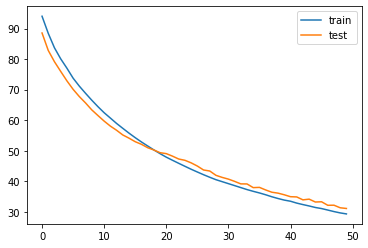

In [101]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [102]:
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert Scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# Invert Scalling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: {:.3f}'.format(rmse))

1095/1095 [==============================] - 4s 3ms/step
RMSE: 61982.372


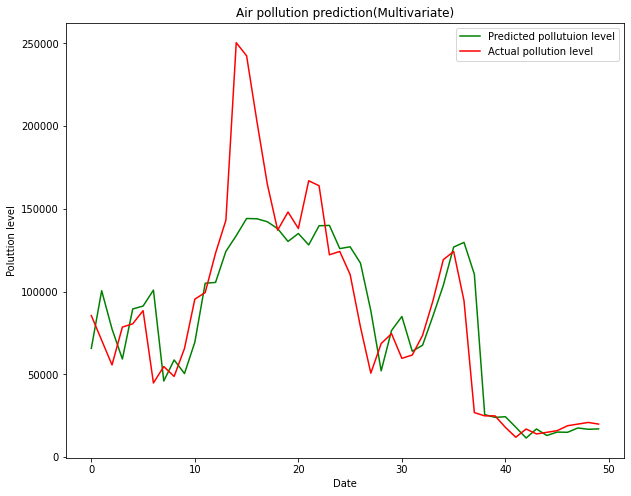

In [103]:
y_tested = inv_y.reshape(-1, 1)
y_pred = inv_yhat.reshape(-1, 1)

plt.figure(figsize = (10, 8))
plt.plot(y_pred[250:300, :], color = 'green', label = 'Predicted pollutuion level')
plt.plot(y_tested[250:300, :], color = 'red', label = 'Actual pollution level')

plt.title('Air pollution prediction(Multivariate)')
plt.xlabel('Date')
plt.ylabel('Poluttion level')
plt.legend()
plt.show()

In [104]:
mse = mean_squared_error(y_tested, y_pred)
# print MAE
mae = (mean_absolute_error(y_tested, y_pred))
print('MAE: %.3f' % mae)
#print('Mean squared error', mse)
print('RMSE' , np.sqrt(mse))
print("Mean of Test data ", np.mean(y_tested))

MAE: 30863.891
RMSE 61982.37206211777
Mean of Test data  92987.11600411241


# Stacked LSTM

Multiple hidden LSTM layers can be stacked one on top of another

In [107]:
#Importing LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam')

history = model.fit(
    train_X,
    train_y,
    epochs = 50,
    batch_size = 72, 
    validation_data = (test_X, test_y),
    verbose = 1, 
    shuffle = False
       )


Epoch 1/50
122/122 [==============================] - 11s 29ms/step - loss: 91.2648 - val_loss: 82.1113
Epoch 2/50
122/122 [==============================] - 2s 20ms/step - loss: 82.5082 - val_loss: 77.8516
Epoch 3/50
122/122 [==============================] - 3s 21ms/step - loss: 78.7649 - val_loss: 74.8013
Epoch 4/50
122/122 [==============================] - 3s 25ms/step - loss: 75.7631 - val_loss: 71.9936
Epoch 5/50
122/122 [==============================] - 2s 20ms/step - loss: 73.0563 - val_loss: 69.5979
Epoch 6/50
122/122 [==============================] - 4s 29ms/step - loss: 70.7220 - val_loss: 67.7854
Epoch 7/50
122/122 [==============================] - 3s 28ms/step - loss: 68.1765 - val_loss: 65.7645
Epoch 8/50
122/122 [==============================] - 4s 30ms/step - loss: 65.8932 - val_loss: 63.5659
Epoch 9/50
122/122 [==============================] - 3s 28ms/step - loss: 63.7608 - val_loss: 62.0629
Epoch 10/50
122/122 [==============================] - 2s 20ms/step - lo

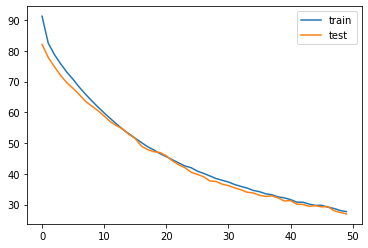

In [108]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [109]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

 # Invert Scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# Invert Scalling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: {:.3f}'.format(rmse))

1095/1095 [==============================] - 5s 3ms/step
RMSE: 58034.347


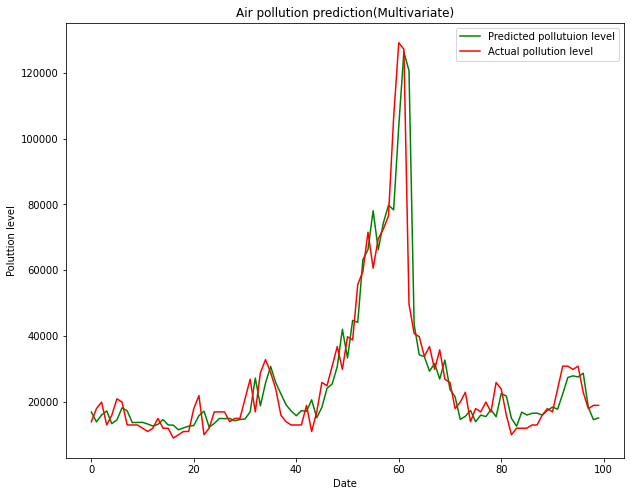

In [110]:
y_tested = inv_y.reshape(-1, 1)
y_pred = inv_yhat.reshape(-1, 1)

plt.figure(figsize = (10, 8))
plt.plot(y_pred[300:400, :], color = 'green', label = 'Predicted pollutuion level')
plt.plot(y_tested[300:400, :], color = 'red', label = 'Actual pollution level')

plt.title('Air pollution prediction(Multivariate)')
plt.xlabel('Date')
plt.ylabel('Poluttion level')
plt.legend()
plt.show()

In [111]:
mse = mean_squared_error(y_tested, y_pred)
# print MAE
mae = (mean_absolute_error(y_tested, y_pred))
print('MAE: %.3f' % mae)
#print('Mean squared error', mse)
print('RMSE' , np.sqrt(mse))
print("Mean of Test data ", np.mean(y_tested))

MAE: 26785.766
RMSE 58034.34681692071
Mean of Test data  92987.11600411241


# Bidirectional LSTM

Bidirectional LSTMs learn the input sequence both forward and backwards and concatenate both interpretations.

In [ ]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

train_X.shape, train_y.shape, test_X.shape, test_y.shape 

In [ ]:
# X_train to reshape to 2D array
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

In [113]:
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape = (train_X.shape[1], train_X.shape[2]))))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam')

history = model.fit(
    train_X,
    train_y,
    epochs = 50, 
    batch_size = 72, 
    validation_data = (test_X, test_y),
    verbose = 1, 
    shuffle = False
  )

Epoch 1/50
122/122 [==============================] - 10s 38ms/step - loss: 89.6090 - val_loss: 78.6281
Epoch 2/50
122/122 [==============================] - 2s 16ms/step - loss: 74.3024 - val_loss: 66.2828
Epoch 3/50
122/122 [==============================] - 2s 16ms/step - loss: 64.4502 - val_loss: 59.6522
Epoch 4/50
122/122 [==============================] - 2s 16ms/step - loss: 57.5374 - val_loss: 55.1352
Epoch 5/50
122/122 [==============================] - 3s 27ms/step - loss: 52.1909 - val_loss: 52.0503
Epoch 6/50
122/122 [==============================] - 2s 18ms/step - loss: 48.0094 - val_loss: 49.6291
Epoch 7/50
122/122 [==============================] - 2s 16ms/step - loss: 44.6946 - val_loss: 47.3022
Epoch 8/50
122/122 [==============================] - 2s 15ms/step - loss: 42.1032 - val_loss: 45.3019
Epoch 9/50
122/122 [==============================] - 2s 16ms/step - loss: 39.8125 - val_loss: 42.8912
Epoch 10/50
122/122 [==============================] - 2s 18ms/step - lo

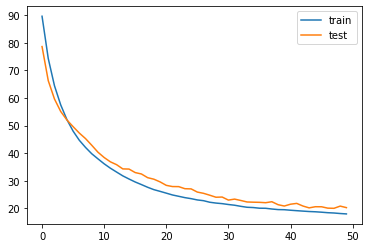

In [114]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [115]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

 # Invert Scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# Invert Scalling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: {:.3f}'.format(rmse))

1095/1095 [==============================] - 4s 3ms/step
RMSE: 38438.843


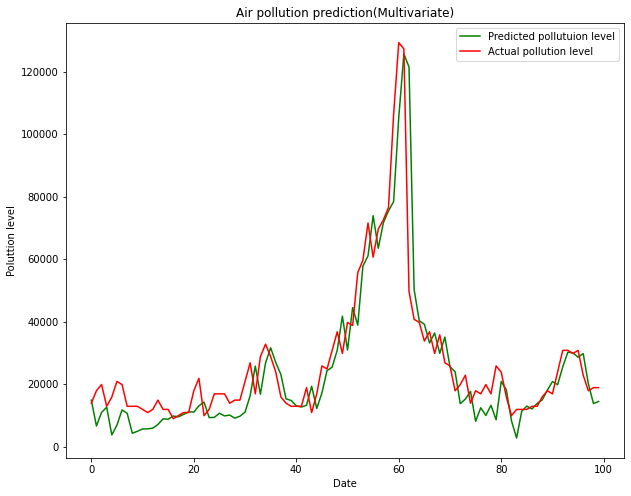

In [116]:
y_tested = inv_y.reshape(-1, 1)
y_pred = inv_yhat.reshape(-1, 1)

plt.figure(figsize = (10, 8))
plt.plot(y_pred[300:400, :], color = 'green', label = 'Predicted pollutuion level')
plt.plot(y_tested[300:400, :], color = 'red', label = 'Actual pollution level')

plt.title('Air pollution prediction(Multivariate)')
plt.xlabel('Date')
plt.ylabel('Poluttion level')
plt.legend()
plt.show()

In [117]:
mse = mean_squared_error(y_tested, y_pred)
# print MAE
mae = (mean_absolute_error(y_tested, y_pred))
print('MAE: %.3f' % mae)
#print('Mean squared error', mse)
print('RMSE' , np.sqrt(mse))
print("Mean of Test data ", np.mean(y_tested))

MAE: 20178.158
RMSE 38438.84306541309
Mean of Test data  92987.11600411241


In [ ]:
Vanilla LSTM
MAE: 30863.891
RMSE 61982.37206211777
Mean of Test data  92987.11600411241

Stacked LSTM
MAE: 26785.766
RMSE 58034.34681692071
Mean of Test data  92987.11600411241

Bidirectional LSTM
MAE: 20178.158
RMSE 38438.84306541309
Mean of Test data  92987.11600411241

Conclusion

-We used a Recurrent Neural Network of architectures for an LSTM, Vanilla , Bidirectional.


-Use the data as features to predict pollution dew point and atmospheric temperature are correlated to the atmospheric pressure.

-Based on the minimum validation losses the model RNN the metrics are close to each other.

 Model of Vanilla LSTM the minimal amount of the error (RMSE: 61.982, Test MAE: 30.863), Model of Stacked LSTM the minimal amount of the error  (RMSE: 58.034, Test MAE: 26.785), Model Bidirectional LSTM the minimal amount of the error (RMSE: 20.178, Test MAE: 38.438)
 Best model Bidirectional LSTM with low score of error.